In [1]:
%matplotlib inline

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from collections import defaultdict, namedtuple

In [3]:
with open('avalon-data/games.json') as f:
    ALL_GAMES = json.load(f)

In [4]:
def get_players(games):
    return set([player['player_id'] for game in games for player in game['players']])

ALL_PLAYERS = get_players(ALL_GAMES)

In [5]:
from trueskill import Rating, rate

In [6]:
def get_blank_ratings(players):
    return {player_id: Rating() for player_id in players}

ALL_RATINGS = get_blank_ratings(ALL_PLAYERS)

In [7]:
def update_ranks(ratings, game):
    good_players = [player['player_id'] for player in game['players'] if not player['spy']]
    bad_players = [player['player_id'] for player in game['players'] if player['spy']]
    
    good_ratings = [ratings[player] for player in good_players]
    bad_ratings = [ratings[player] for player in bad_players]
    
    result = [1, 0] if game['spies_win'] else [0, 1]
    
    new_good_ratings, new_bad_ratings = rate([good_ratings, bad_ratings], ranks=result)
    
    for player, rating in zip(good_players, new_good_ratings):
        ratings[player] = rating
    
    for player, rating in zip(bad_players, new_bad_ratings):
        ratings[player] = rating

In [8]:
def calculate_ratings(blank_ratings, games):
    for game in games:
        update_ranks(blank_ratings, game)
        
calculate_ratings(ALL_RATINGS, ALL_GAMES)

In [9]:
def get_ratings_from_games(games):
    players = get_players(games)
    ratings = get_blank_ratings(players)
    calculate_ratings(ratings, games)
    return ratings

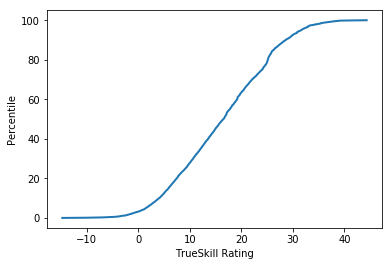

In [10]:
def plot_rating_vs_percentile(ratings):
    ratings = sorted([rating.mu for rating in ALL_RATINGS.values()])
    y = np.array([i for i in range(len(ratings))])/float(len(ratings))*100
    plt.ylabel('Percentile')
    plt.xlabel('TrueSkill Rating')
    plt.plot(ratings, y, linewidth=2)
    
plot_rating_vs_percentile(ALL_RATINGS)

In [11]:
def get_games_played_count(games):
    games_played = defaultdict(lambda: 0)
    for game in ALL_GAMES:
        for player in game['players']:
            games_played[player['player_id']] += 1
    return games_played

ALL_GAMES_PLAYED_COUNT = get_games_played_count(ALL_GAMES)

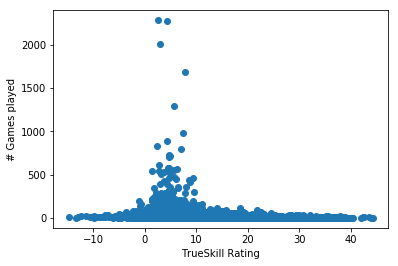

In [12]:
def plot_rating_vs_games_played(players, games_played, ratings):
    y = [games_played[player] for player in players]
    x = [ratings[player].mu for player in players]
    plt.ylabel('# Games played')
    plt.xlabel('TrueSkill Rating')
    plt.scatter(x, y)

plot_rating_vs_games_played(ALL_PLAYERS, ALL_GAMES_PLAYED_COUNT, ALL_RATINGS)

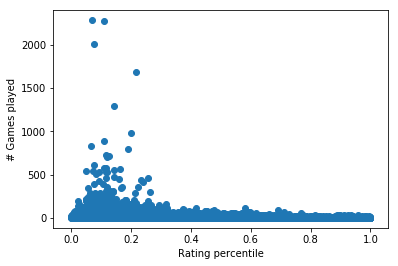

In [13]:
def plot_percentile_vs_games_played(players, games_played, ratings):
    pairs = [(ratings[player].mu, games_played[player]) for player in players]
    sorted_pairs = sorted(pairs)
    rating, games_played = zip(*sorted_pairs)
    percentile = np.array(range(len(rating)))/float(len(rating))
    plt.ylabel('# Games played')
    plt.xlabel('Rating percentile')
    plt.scatter(percentile, games_played)
    
plot_percentile_vs_games_played(ALL_PLAYERS, ALL_GAMES_PLAYED_COUNT, ALL_RATINGS)

In [14]:
__GameResult_ATTRIBUTES = ['num_players', 'missions', 'm_guess_attempted', 'm_guess_correct']
class GameResult(namedtuple('GameResult', __GameResult_ATTRIBUTES)):
    @property
    def spies_win(self):
        return self.m_guess_correct or sum(self.missions) < 3

In [15]:
def get_game_result(game):
    num_players = len(game['players'])
    spies_win = game['spies_win']
    missions = []
    merlin_guessed = False
    merlin_correct = False
    for mission_number, mission in enumerate(game['log']):
        num_fails = sum(result == 'Fail' for result in mission['mission'])
        failed = num_fails > 1 if (mission_number == 3 and num_players > 6) else num_fails > 0
        missions.append(not failed)
        if 'findMerlin' in mission:
            merlinData = mission['findMerlin']
            merlin_guessed = True
            merlin_correct = merlinData['merlin'] == merlinData['merlin_guess']
    result = GameResult(num_players, tuple(missions), merlin_guessed, merlin_correct)
    return result

In [16]:
def filter_unknown_wins(games):
    def is_valid_game(game):
        result = get_game_result(game)
        if result.spies_win != game['spies_win']:
            return False
        fails = 0
        passes = 0
        for mission_result in result.missions:
            fails += 0 if mission_result else 1
            passes += 1 if mission_result else 0
            if (fails >= 3 or passes >= 3) and (fails + passes != len(result.missions)):
                return False
        if fails < 3 and passes < 3:
            return False

        return True
    return [game for game in games if is_valid_game(game)]

VALID_GAMES = filter_unknown_wins(ALL_GAMES)
VALID_GAMES_PLAYED_COUNT = get_games_played_count(VALID_GAMES)

In [17]:
def filter_low_experience_games(games, games_played, cutoff=3):
    def high_experience(game):
        return all(games_played[player['player_id']] >= cutoff for player in game['players'])
    return [game for game in games if high_experience(game)]

FILTERED_GAMES = filter_low_experience_games(VALID_GAMES, VALID_GAMES_PLAYED_COUNT, cutoff=2)

In [18]:
VALID_PLAYERS = get_players(VALID_GAMES)
VALID_RATINGS = get_blank_ratings(VALID_PLAYERS)
calculate_ratings(VALID_RATINGS, VALID_GAMES)

In [19]:
def print_top_endings(games, groups=['missions', 'm_guess_correct'], n=10):
    counts = defaultdict(lambda: 0)
    for game in games:
        result = get_game_result(game)
        attrs = tuple([getattr(result, group) for group in groups])
        counts[(result.spies_win, attrs)] += 1
        
    for (spies_win, attrs), count in sorted(counts.items(), reverse=True, key=lambda (_, count): count):
        text = ", ".join("{}={: <40}".format(key, val) for key, val in zip(groups, attrs))
        print "Bad_Win: {: >1}, Count: {: >4}, Result: {}".format(spies_win, count, text)

In [20]:
print_top_endings(VALID_GAMES)

Bad_Win: 0, Count: 2247, Result: missions=(True, True, True)                      , m_guess_correct=0                                       
Bad_Win: 0, Count: 1838, Result: missions=(True, False, True, True)               , m_guess_correct=0                                       
Bad_Win: 1, Count: 1189, Result: missions=(True, True, True)                      , m_guess_correct=1                                       
Bad_Win: 1, Count: 1118, Result: missions=(True, False, False, False)             , m_guess_correct=0                                       
Bad_Win: 1, Count: 1012, Result: missions=(True, False, True, True)               , m_guess_correct=1                                       
Bad_Win: 1, Count:  982, Result: missions=(True, False, True, False, False)       , m_guess_correct=0                                       
Bad_Win: 0, Count:  940, Result: missions=(True, True, False, True)               , m_guess_correct=0                                       
Bad_Win: 0, C

In [21]:
class GameNode(object):
    def __init__(self):
        self.game_end = False
        self.fails = 0
        self.succeeds = 0
        self.win = 0
        self.loss = 0
        self._next = defaultdict(lambda: GameNode())
        
    def __getitem__(self, item):
        return self._next[item]
    
    def __str__(self):
        games = self.win + self.loss
        loss_prob = float(self.loss)/games
        fail_prob = float(self.fails)/(self.fails + self.succeeds) if (self.fails + self.succeeds) != 0 else float('nan')
        return "<GameNode loss_prob={:0.3f} fail_prob={:0.3f} games={}>".format(loss_prob, fail_prob, games)
    
    def __repr__(self):
        return self.__str__()

In [22]:
def build_game_tree(games):
    root = GameNode()
    for game in games:
        result = get_game_result(game)
        current = root
        for mission in result.missions:
            current.win += 0 if result.spies_win else 1
            current.loss += 1 if result.spies_win else 0
            current.succeeds += 1 if mission else 0
            current.fails += 0 if mission else 1
            current = current[mission]
        current.win += 0 if result.spies_win else 1
        current.loss += 1 if result.spies_win else 0
    return root

In [23]:
VALID_GAME_TREE = build_game_tree(VALID_GAMES)

In [24]:
VALID_GAME_TREE[True][True][False][True]

<GameNode loss_prob=0.322 fail_prob=nan games=1386>

In [25]:
def rolling_average(values, rolling_width=100):
    average = sum(value for value in values[:rolling_width])/float(rolling_width)
    averages = [average]
    for i in range(rolling_width, len(values) - rolling_width):
        old_value = values[i - rolling_width]
        new_value = values[i]
        average = (average*rolling_width - old_value + new_value)/float(rolling_width)
        averages.append(average)
    return averages

In [26]:
def get_elo_diffs_and_outcomes(games, ratings):
    result = []
    for game in games:
        game_result = get_game_result(game)
        num_spies = sum(player['spy'] for player in game['players'])
        num_good = len(game['players']) - num_spies
        spies_elo = [ratings[player['player_id']].mu for player in game['players'] if player['spy']]
        good_elo = [ratings[player['player_id']].mu for player in game['players'] if not player['spy']]
        
        elo_diff = sum(good_elo)/len(good_elo) - sum(spies_elo)/len(spies_elo)
        result.append((elo_diff, float(not game_result.spies_win)))
    return result

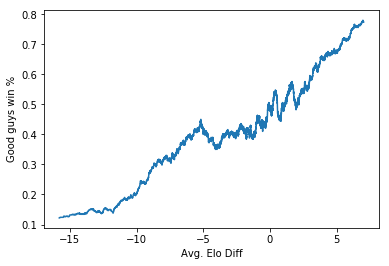

In [27]:
def plot_elo_diff_vs_outcome(games, ratings, rolling_width=500):
    results = get_elo_diffs_and_outcomes(games, ratings)
    results = sorted(results)
    
    elo_diffs, outcomes = zip(*results)
    ravg_elo = rolling_average(elo_diffs, rolling_width=rolling_width)
    ravg_win = rolling_average(outcomes, rolling_width=rolling_width)
    
    plt.ylabel('Good guys win %')
    plt.xlabel('Avg. Elo Diff')
    plt.plot(ravg_elo, ravg_win)
    
plot_elo_diff_vs_outcome(VALID_GAMES, VALID_RATINGS)

In [67]:
def group_and_average(arr, group=lambda x: x[0], stat=lambda x: x[1]):
    counts = defaultdict(lambda: 0)
    stat_total = defaultdict(lambda: 0)
    
    for val in arr:
        counts[group(val)] += 1
        stat_total[group(val)] += stat(val)
    
    results = []
    for k in counts.keys():
        results.append((k, float(stat_total[k])/counts[k], counts[k]))
    return results
    

In [68]:
def get_mission_counts(games):
    results = []
    for game in games:
        mission_counts = {}
        for p in [ player['player_id'] for player in game['players'] ]:
            mission_counts[p] = 0
        for mission in game['log']:
            team = None
            for prop_round in ['1', '2', '3', '4', '5']:
                if prop_round not in mission:
                    break
                team = mission[prop_round]['team']
            for member in team:
                player = game['players'][member]
                mission_counts[player['player_id']] += 1
        for player in mission_counts:
            results.append((player, mission_counts[player], len(game['log'])))
    return results

get_mission_counts(VALID_GAMES)
None

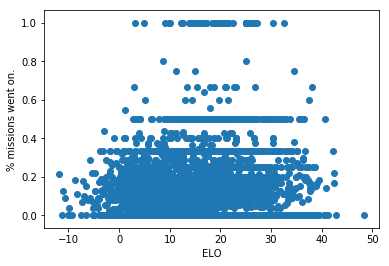

In [72]:
def plot_elo_vs_mission_count(games, ratings, rolling_width=1):
    mission_counts = get_mission_counts(games)
    players, missions, total_missions = zip(*mission_counts)
    missions = np.array(missions) / np.array(total_missions)
    
    players_and_missions = zip(players, missions)
    
    grouped = group_and_average(players_and_missions)
    
    grouped = sorted(grouped, key=lambda x: ratings[x[0]].mu)
    
    elos = [ratings[player].mu for player, _, _ in grouped]
    mission_counts = [avg_count for _, avg_count, _, in grouped]
    
    ravg_elo = rolling_average(elos, rolling_width=rolling_width)
    ravg_mission = rolling_average(mission_counts, rolling_width=rolling_width)
    
    plt.ylabel('% missions went on.')
    plt.xlabel('ELO')
    plt.scatter(elos, mission_counts)
    
plot_elo_vs_mission_count(VALID_GAMES, VALID_RATINGS)

In [107]:
def get_mission_fail_counts(games):
    results = []
    for game in games:
        mission_succeeds = {}
        mission_fails = {}
        for p in [ player['player_id'] for player in game['players'] if player['spy'] ]:
            mission_succeeds[p] = 0
            mission_fails[p] = 0
            
        game_result = get_game_result(game)
        for i, mission in enumerate(game['log']):
            team = None
            for prop_round in ['1', '2', '3', '4', '5']:
                if prop_round not in mission:
                    break
                team = mission[prop_round]['team']
            votes = mission['mission']
            for member, vote in zip(team, votes):
                player = game['players'][member]
                if player['spy']:
                    if not game_result.missions[i]:
                        mission_fails[player['player_id']] += 1
                    else:
                        mission_succeeds[player['player_id']] += 1
        for player in mission_succeeds:
            if mission_fails[player] + mission_succeeds[player] == 0:
                continue
            results.append((player, mission_fails[player], mission_succeeds[player]))
    return results

get_mission_fail_counts(VALID_GAMES)
None

[[1.         0.06605794]
 [0.06605794 1.        ]]


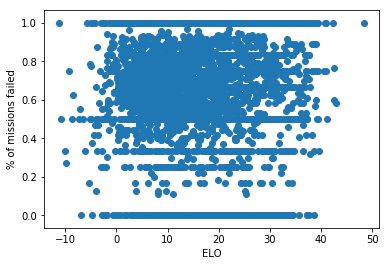

In [110]:
def plot_elo_vs_mission_fails(games, ratings, rolling_width=1000):
    mission_counts = get_mission_fail_counts(games)
    players, missions_failed, missions_passed = zip(*mission_counts)
    missions_failed = np.array(missions_failed)
    missions_passed = np.array(missions_passed)
    perc_failed = missions_failed / (missions_failed + missions_passed + 0.0)
    
    players_and_perc_failed = zip(players, perc_failed)
    
    grouped = group_and_average(players_and_perc_failed)
    
    grouped = sorted(grouped, key=lambda x: ratings[x[0]].mu)
    
    elos = [ratings[player].mu for player, _, _ in grouped]
    avg_fails = [avg_fail for _, avg_fail, _, in grouped]
    
    ravg_elo = rolling_average(elos, rolling_width=rolling_width)
    ravg_perc_failed = rolling_average(avg_fails, rolling_width=rolling_width)
    
    print np.corrcoef(elos, avg_fails)
    
    plt.ylabel('% of missions failed')
    plt.xlabel('ELO')
    plt.scatter(elos, avg_fails)
    
plot_elo_vs_mission_fails(VALID_GAMES, VALID_RATINGS)

In [109]:
def get_mission_counts(games):
    good_mission_counts = defaultdict(lambda: [0, 0, 0, 0, 0])
    bad_mission_counts = defaultdict(lambda: [0, 0, 0, 0, 0])
    mission_fails = defaultdict(lambda: [0, 0, 0, 0, 0])
    for game in games:
        
        game_result = get_game_result(game)
        
        for mission_num, mission in enumerate(game['log']):
            team = None
            for prop_round in ['1', '2', '3', '4', '5']:
                if prop_round not in mission:
                    break
                team = mission[prop_round]['team']
            players = [game['players'][player] for player in team]
            votes = mission['mission']
            
            for player, vote in zip(players, votes):
                if player['spy']:
                    bad_mission_counts[player['player_id']][mission_num] += 1
                else:
                    good_mission_counts[player['player_id']][mission_num] += 1
                    
                if not game_result.missions[mission_num]:
                    mission_fails[player['player_id']][mission_num] += 1

    return good_mission_counts, bad_mission_counts, mission_fails

get_mission_counts(VALID_GAMES)

(defaultdict(<function __main__.<lambda>>,
             {16384: [3, 1, 5, 3, 1],
              16388: [0, 1, 0, 1, 0],
              16389: [2, 3, 3, 2, 2],
              16390: [7, 6, 5, 3, 3],
              16391: [2, 3, 2, 3, 2],
              16392: [1, 1, 1, 2, 1],
              11: [15, 30, 30, 33, 15],
              16396: [0, 1, 0, 0, 0],
              16397: [0, 0, 0, 1, 1],
              14: [8, 7, 6, 4, 5],
              15: [2, 5, 1, 3, 2],
              16: [1, 1, 1, 1, 1],
              18: [2, 8, 6, 4, 5],
              16403: [1, 1, 0, 1, 1],
              20: [0, 0, 0, 1, 0],
              16405: [8, 6, 5, 5, 6],
              16406: [2, 4, 3, 3, 0],
              23: [0, 1, 1, 1, 0],
              25: [49, 86, 84, 78, 55],
              26: [41, 52, 42, 55, 30],
              27: [43, 52, 58, 58, 35],
              16412: [1, 0, 1, 1, 0],
              29: [12, 21, 21, 17, 14],
              30: [10, 24, 21, 16, 12],
              31: [20, 42, 45, 43, 25],
           

In [96]:
x[0]

[0, 0, 0, 0, 0]

In [97]:
x[1]

[0, 0, 0, 0, 0]

In [98]:
x[1][0] += 1

In [99]:
x[0]


[0, 0, 0, 0, 0]

In [101]:
x[1]

[1, 0, 0, 0, 0]

In [ ]:
defaultdict(lambda: [0, 0, 0, 0, 0])

